In [2]:
import pandas as pd
import numpy as np
import requests
import io
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Direct download of the CSV file
# url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00360/AirQualityUCI.csv"
# response = requests.get(url)
# air_quality = pd.read_csv(io.StringIO(response.content.decode('ISO-8859-1')), 
#                           sep=';', decimal=',')
air_quality = pd.read_csv('../data/air_quality/AirQualityUCI.csv', sep=';', decimal=',')
# Clean the data
# Convert date and time columns to datetime
air_quality['Date'] = pd.to_datetime(air_quality['Date'], format='%d/%m/%Y')
air_quality['Time'] = pd.to_datetime(air_quality['Time'], format='%H.%M.%S').dt.time

# Replace missing values (marked as -200) with NaN
air_quality = air_quality.replace(-200, np.nan)

# Drop columns with too many missing values
air_quality = air_quality.dropna(axis=1, thresh=len(air_quality)*0.7)

# Drop rows with any missing values
air_quality = air_quality.dropna()

# Create a binary target variable (1 if CO level is above median, 0 otherwise)
co_median = air_quality['CO(GT)'].median()
air_quality['target'] = (air_quality['CO(GT)'] > co_median).astype(int)

# Select features
features = ['PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)', 'PT08.S4(NO2)', 
            'PT08.S5(O3)', 'T', 'RH', 'AH']
X = air_quality[features]
y = air_quality['target']

# Split the data chronologically
train_size = int(0.7 * len(air_quality))
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

# Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

# Evaluate the model
y_pred = model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.4f}")
print(classification_report(y_test, y_pred))

# Create time intervals for drift detection
def create_time_intervals(data, interval_size='3M'):
    """Create time intervals from data for drift detection."""
    # Sort by datetime
    data = data.sort_values('DateTime')
    
    # Group data into intervals
    intervals = []
    for name, group in data.groupby(pd.Grouper(key='DateTime', freq=interval_size)):
        if not group.empty:
            intervals.append(group)
    
    return intervals

air_quality['DateTime'] = pd.to_datetime(air_quality['Date'].astype(str)+' '+air_quality['Time'].astype(str))
# Create intervals for drift detection
test_with_time = air_quality.iloc[train_size:].copy()
intervals = create_time_intervals(test_with_time, '2W') 

print(f"Created {len(intervals)} time intervals for drift detection")
for i, interval in enumerate(intervals):
    if not interval.empty:
        start_date = interval['DateTime'].min()
        end_date = interval['DateTime'].max()
        target_rate = interval['target'].mean() * 100
        print(f"Interval {i+1}: {start_date} to {end_date}, {len(interval)} samples, Target rate: {target_rate:.4f}%")

Model Accuracy: 0.8785
              precision    recall  f1-score   support

           0       0.92      0.86      0.89      1160
           1       0.84      0.90      0.87       923

    accuracy                           0.88      2083
   macro avg       0.88      0.88      0.88      2083
weighted avg       0.88      0.88      0.88      2083

Created 9 time intervals for drift detection
Interval 1: 2004-12-21 23:00:00 to 2004-12-26 23:00:00, 109 samples, Target rate: 71.5596%
Interval 2: 2004-12-27 00:00:00 to 2005-01-09 23:00:00, 178 samples, Target rate: 52.2472%
Interval 3: 2005-01-10 00:00:00 to 2005-01-23 00:00:00, 287 samples, Target rate: 57.8397%
Interval 4: 2005-01-24 02:00:00 to 2005-02-06 23:00:00, 287 samples, Target rate: 29.6167%
Interval 5: 2005-02-07 00:00:00 to 2005-02-20 23:00:00, 246 samples, Target rate: 41.4634%
Interval 6: 2005-02-21 00:00:00 to 2005-03-06 23:00:00, 315 samples, Target rate: 41.9048%
Interval 7: 2005-03-07 00:00:00 to 2005-03-20 23:00:00, 315


Air Quality Classification Model Feature Ranking:
----------------------------------------
1. PT08.S2(NMHC) (0.3816)
2. PT08.S1(CO) (0.1702)
3. PT08.S5(O3) (0.1520)
4. PT08.S3(NOx) (0.1191)
5. PT08.S4(NO2) (0.0597)
6. AH (0.0491)
7. T (0.0377)
8. RH (0.0306)


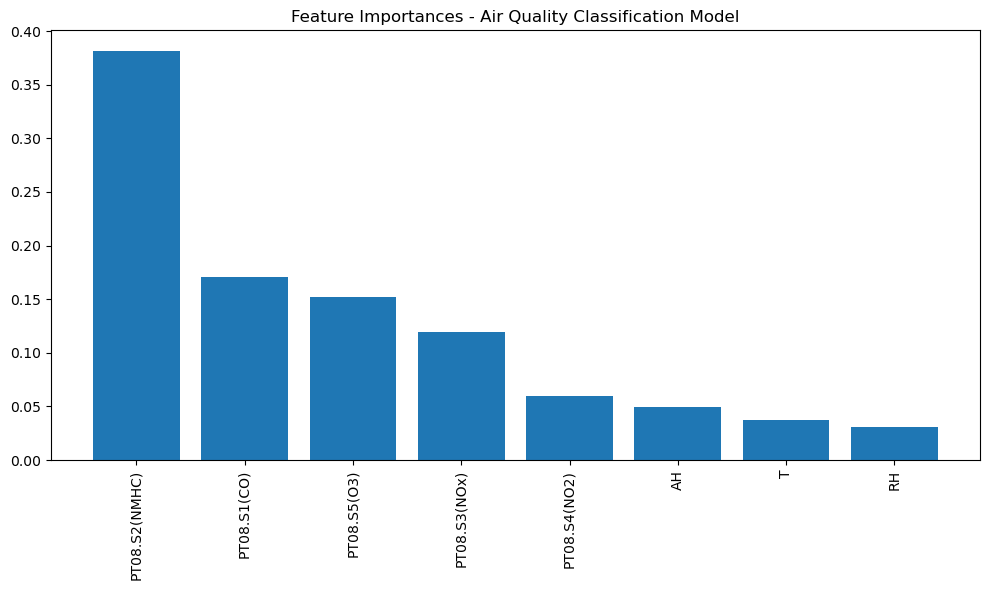

In [7]:
# After training each random forest classifier
def print_feature_importance(model, feature_names, model_name="Random Forest"):
    """
    Print and visualize feature importances for a trained random forest model
    
    Parameters:
    -----------
    model : RandomForestClassifier
        The trained model to analyze
    feature_names : list
        List of feature names corresponding to the input features
    model_name : str
        Name of the model for display purposes
    """
    # Get feature importances
    importances = model.feature_importances_
    
    # Sort feature importances in descending order and get corresponding indices
    indices = np.argsort(importances)[::-1]
    
    # Print feature ranking
    print(f"\n{model_name} Feature Ranking:")
    print("-" * 40)
    for i, idx in enumerate(indices):
        print(f"{i+1}. {feature_names[idx]} ({importances[idx]:.4f})")
    
    # Create a bar chart of feature importances
    plt.figure(figsize=(10, 6))
    plt.title(f"Feature Importances - {model_name}")
    plt.bar(range(len(feature_names)), importances[indices], align="center")
    plt.xticks(range(len(feature_names)), [feature_names[i] for i in indices], rotation=90)
    plt.tight_layout()
    plt.show()

# Example usage for each of your random forest models:
# Assuming X_train contains your features and columns gives feature names
feature_names = X_train.columns.tolist()  # Adjust if using a different data structure

# For each model you've trained
print_feature_importance(model, feature_names, "Air Quality Classification Model")

In [4]:
# Import necessary libraries for drift detection
from scipy.stats import wasserstein_distance
from scipy.spatial.distance import jensenshannon
from sklearn.metrics import accuracy_score, classification_report, precision_recall_fscore_support
import numpy as np
from sklearn.neighbors import KernelDensity

def calculate_wasserstein_distance(dist1, dist2):
    """Calculate Wasserstein distance between two distributions."""
    return wasserstein_distance(dist1, dist2)

def calculate_kl_divergence(dist1, dist2, n_bins=30):
    """
    Calculate KL divergence between two distributions.
    Using Jensen-Shannon divergence as a symmetric alternative to KL.
    
    Args:
        dist1: First distribution samples
        dist2: Second distribution samples
        n_bins: Number of bins for discretization
    """
    # Convert continuous distributions to discrete probability distributions
    hist1, bin_edges = np.histogram(dist1, bins=n_bins, density=True)
    hist2, _ = np.histogram(dist2, bins=bin_edges, density=True)
    
    # Normalize to create probability distributions
    bin_width = bin_edges[1] - bin_edges[0]
    p = hist1 * bin_width
    q = hist2 * bin_width
    
    # Add small epsilon to avoid division by zero
    epsilon = 1e-10
    p = p + epsilon
    q = q + epsilon
    
    # Normalize again to ensure probabilities sum to 1
    p = p / np.sum(p)
    q = q / np.sum(q)
    
    # Calculate Jensen-Shannon divergence (symmetric version of KL)
    js_distance = jensenshannon(p, q)
    
    # Return JS divergence (which is the square root of JS distance)
    return js_distance ** 2

def estimate_fisher_information(samples, bandwidth=0.1):
    """Estimate Fisher Information Matrix for a set of samples."""
    # For univariate data, Fisher Information is the negative expectation of 
    # the second derivative of the log-likelihood
    kde = KernelDensity(bandwidth=bandwidth, kernel='gaussian')
    kde.fit(samples.reshape(-1, 1))
    
    # Estimate density at sample points
    log_density = kde.score_samples(samples.reshape(-1, 1))
    density = np.exp(log_density)
    
    # Calculate Fisher Information (simplified for univariate case)
    # For KDE, this approximates to: ∫ (∇log p(x))² p(x) dx
    grad_log_density = np.gradient(log_density)
    grad_samples = np.gradient(samples)
    
    # Avoid division by zero
    valid_indices = np.abs(grad_samples) > 1e-10
    if np.sum(valid_indices) > 0:
        grad_log_p = grad_log_density[valid_indices] / grad_samples[valid_indices]
        fisher_info = np.mean(grad_log_p ** 2)
    else:
        # If all gradients are near zero, use an alternative approach
        fisher_info = np.var(log_density)  # A reasonable proxy
    
    return fisher_info

def detect_distribution_drift(intervals, features, scenario='interval', test_data = []):
    """Detect drift between consecutive time intervals."""
    results = []
    
    # For each pair of consecutive intervals
    for i in range(len(intervals) - 1):
    # for i in range(1):

        # Scenario 3 [Main Scenario]: Temporal shifts between Interval
        if scenario == 'interval':
            print(f"Comparing Interval {i+1} vs Interval {i+2}:")
            interval_drifts = []
            
            # Get the data for next and next interval
            current_data = intervals[i]
            next_data = intervals[i+1]

            # Helper procedure to ensure datasets are same size (if needed)
            if len(current_data) != len(next_data):
                next_data = next_data[:len(current_data)]

        # Scenario 2 [Test Scenario]: Shifts between Interval / Subset and Test Dataset
        elif scenario == 'test':
            print(f"Comparing Interval {i+1} vs Test Data:")
            interval_drifts = []
            
            # Get the data for next and next interval
            current_data = intervals[i]
            next_data = test_data
        
        # Calculate drift metrics for each feature
        for feature in features:
            if features.index(feature) % 5 == 0:
                print(f"On Feature {features.index(feature)} of {len(features)}")

            # Method 1: Min-Max Normalization (scales to exactly [0, 1])
            current_dist = (current_data[feature].values-current_data[feature].values.min())/(current_data[feature].values.max()-current_data[feature].values.min())
            next_dist = (next_data[feature].values-next_data[feature].values.min())/(next_data[feature].values.max()-next_data[feature].values.min())
            # current_dist = current_data[feature].values
            # next_dist = next_data[feature].values

            # Calculate Wasserstein distance
            w_dist = calculate_wasserstein_distance(current_dist, next_dist)
            
            # Calculate KL divergence [Only applicable to Same Size Datasets (i.e., intervals)]
            if scenario == 'interval':
                kl_div = calculate_kl_divergence(current_dist, next_dist)
            else:
                kl_div = []

            # Estimate Fisher Information
            fisher_current = estimate_fisher_information(current_dist)
            fisher_next = estimate_fisher_information(next_dist)
            fisher_diff = abs(fisher_current - fisher_next)
            
            interval_drifts.append({
                'feature': feature,
                'wasserstein': w_dist,
                'kl_divergence': kl_div,
                'fisher_diff': fisher_diff
            })
        
        if scenario == 'interval':
            results.append({
                'interval_pair': f"{i+1}-{i+2}",
                'feature_drifts': interval_drifts,
                'avg_wasserstein': np.mean([d['wasserstein'] for d in interval_drifts]),
                'avg_kl_divergence': np.mean([d['kl_divergence'] for d in interval_drifts]),
                'avg_fisher_diff': np.mean([d['fisher_diff'] for d in interval_drifts])
            })
        elif scenario == 'test':
            results.append({
                'interval_pair': f"{i+1}-Test",
                'feature_drifts': interval_drifts,
                'avg_wasserstein': np.mean([d['wasserstein'] for d in interval_drifts]),
                'avg_kl_divergence': 'NA',
                'avg_fisher_diff': np.mean([d['fisher_diff'] for d in interval_drifts])
            })
    return results

# Run drift detection (Scenario 3 [Main Scenario])
drift_results = detect_distribution_drift(intervals, features)

# Print drift detection results
print("\nScenario 3 [Main Scenario] Drift Detection Results:")
for result in drift_results:
    print(f"\nIntervals {result['interval_pair']}:")
    print(f"Average Wasserstein Distance: {result['avg_wasserstein']:.4f}")
    print(f"Average KL Divergence: {result['avg_kl_divergence']:.4f}")
    print(f"Average Fisher Information Difference: {result['avg_fisher_diff']:.4f}")
    
    # Find top drifting features
    top_features_w = sorted(result['feature_drifts'], key=lambda x: x['wasserstein'], reverse=True)[:3]
    top_features_kl = sorted(result['feature_drifts'], key=lambda x: x['kl_divergence'], reverse=True)[:3]
    top_features_f = sorted(result['feature_drifts'], key=lambda x: x['fisher_diff'], reverse=True)[:3]
    
    print("\nTop drifting features (Wasserstein):")
    for feat in top_features_w:
        print(f"{feat['feature']}: {feat['wasserstein']:.4f}")
    print("\nTop drifting features (KL Divergence):")
    for feat in top_features_kl:
        print(f"{feat['feature']}: {feat['kl_divergence']:.4f}")
    print("\nTop drifting features (Fisher Information):")
    for feat in top_features_f:
        print(f"{feat['feature']}: {feat['fisher_diff']:.4f}")
    
    # Visualize drift over time
    interval_idx = int(result['interval_pair'].split('-')[0]) - 1
    next_interval_idx = interval_idx + 1
    
    # Model performance in each interval
    X_current = scaler.transform(intervals[interval_idx][features])
    y_current = intervals[interval_idx]['target']
    X_next = scaler.transform(intervals[next_interval_idx][features])
    y_next = intervals[next_interval_idx]['target']
    
    # Evaluate model on each interval
    y_pred_current = model.predict(X_current)
    y_pred_next = model.predict(X_next)
    
    # Calculate performance metrics
    precision_current, recall_current, f1_current, _ = precision_recall_fscore_support(
        y_current, y_pred_current, average='binary', zero_division=0)
    precision_next, recall_next, f1_next, _ = precision_recall_fscore_support(
        y_next, y_pred_next, average='binary', zero_division=0)
    
    print(f"\nModel Performance Changes:")
    print(f"F1 Score: {f1_current:.4f} → {f1_next:.4f} (Δ: {f1_next-f1_current:.4f})")
    print(f"Precision: {precision_current:.4f} → {precision_next:.4f} (Δ: {precision_next-precision_current:.4f})")
    print(f"Recall: {recall_current:.4f} → {recall_next:.4f} (Δ: {recall_next-recall_current:.4f})")

# Run drift detection (Scenario 2 [Test Scenario])
test_drift_results = detect_distribution_drift(intervals, features, scenario='test', test_data=test_with_time)

# Print drift detection results
print("\nScenario 2 [Test Scenario] Drift Detection Results :")
for result in test_drift_results:
    print(f"\nIntervals {result['interval_pair']}:")
    print(f"Average Wasserstein Distance: {result['avg_wasserstein']:.4f}")
    # print(f"Average KL Divergence: {result['avg_kl_divergence']:.4f}")
    print(f"Average Fisher Information Difference: {result['avg_fisher_diff']:.4f}")
    
    # Find top drifting features
    top_features_w = sorted(result['feature_drifts'], key=lambda x: x['wasserstein'], reverse=True)[:3]
    top_features_kl = sorted(result['feature_drifts'], key=lambda x: x['kl_divergence'], reverse=True)[:3]
    top_features_f = sorted(result['feature_drifts'], key=lambda x: x['fisher_diff'], reverse=True)[:3]

    print("\nTop drifting features (Wasserstein):")
    for feat in top_features_w:
        print(f"{feat['feature']}: {feat['wasserstein']:.4f}")
    # print("\nTop drifting features (KL Divergence):")
    # for feat in top_features_kl:
    #     print(f"{feat['feature']}: {feat['kl_divergence']:.4f}")
    print("\nTop drifting features (Fisher Information):")
    for feat in top_features_f:
        print(f"{feat['feature']}: {feat['fisher_diff']:.4f}")
    
    # Visualize drift over time
    interval_idx = int(result['interval_pair'].split('-')[0]) - 1
    next_interval_idx = interval_idx + 1
    
    # Model performance in each interval
    test_data = test_with_time
    X_current = scaler.transform(intervals[interval_idx][features])
    y_current = intervals[interval_idx]['target']
    X_next = scaler.transform(test_data[features])
    y_next = test_data['target']
    
    # Evaluate model on each interval
    y_pred_current = model.predict(X_current)
    y_pred_next = model.predict(X_next)
    
    # Calculate performance metrics
    precision_current, recall_current, f1_current, _ = precision_recall_fscore_support(
        y_current, y_pred_current, average='binary', zero_division=0)
    precision_next, recall_next, f1_next, _ = precision_recall_fscore_support(
        y_next, y_pred_next, average='binary', zero_division=0)
    
    print(f"\nModel Performance Changes:")
    print(f"F1 Score: {f1_current:.4f} → {f1_next:.4f} (Δ: {f1_next-f1_current:.4f})")
    print(f"Precision: {precision_current:.4f} → {precision_next:.4f} (Δ: {precision_next-precision_current:.4f})")
    print(f"Recall: {recall_current:.4f} → {recall_next:.4f} (Δ: {recall_next-recall_current:.4f})")

Comparing Interval 1 vs Interval 2:
On Feature 0 of 8
On Feature 5 of 8
Comparing Interval 2 vs Interval 3:
On Feature 0 of 8
On Feature 5 of 8
Comparing Interval 3 vs Interval 4:
On Feature 0 of 8
On Feature 5 of 8
Comparing Interval 4 vs Interval 5:
On Feature 0 of 8
On Feature 5 of 8
Comparing Interval 5 vs Interval 6:
On Feature 0 of 8
On Feature 5 of 8
Comparing Interval 6 vs Interval 7:
On Feature 0 of 8
On Feature 5 of 8
Comparing Interval 7 vs Interval 8:
On Feature 0 of 8
On Feature 5 of 8
Comparing Interval 8 vs Interval 9:
On Feature 0 of 8
On Feature 5 of 8

Scenario 3 [Main Scenario] Drift Detection Results:

Intervals 1-2:
Average Wasserstein Distance: 0.0836
Average KL Divergence: 0.1340
Average Fisher Information Difference: 5.3187

Top drifting features (Wasserstein):
AH: 0.1149
PT08.S1(CO): 0.1064
RH: 0.1010

Top drifting features (KL Divergence):
AH: 0.1796
PT08.S5(O3): 0.1529
T: 0.1518

Top drifting features (Fisher Information):
RH: 8.7136
PT08.S1(CO): 7.7522
PT08.

In [8]:
# Persist results as needed (Scenario 3)
import json

data = drift_results
file_path = '../results/test_results_senario3_airData_05062025.json'

with open(file_path, 'w') as file:
    json.dump(data, file, indent=4)

In [9]:
# Persist results as needed (Scenario 3)
import json

data = test_drift_results
file_path = '../results/test_results_senario2_airData_05062025.json'

with open(file_path, 'w') as file:
    json.dump(data, file, indent=4)

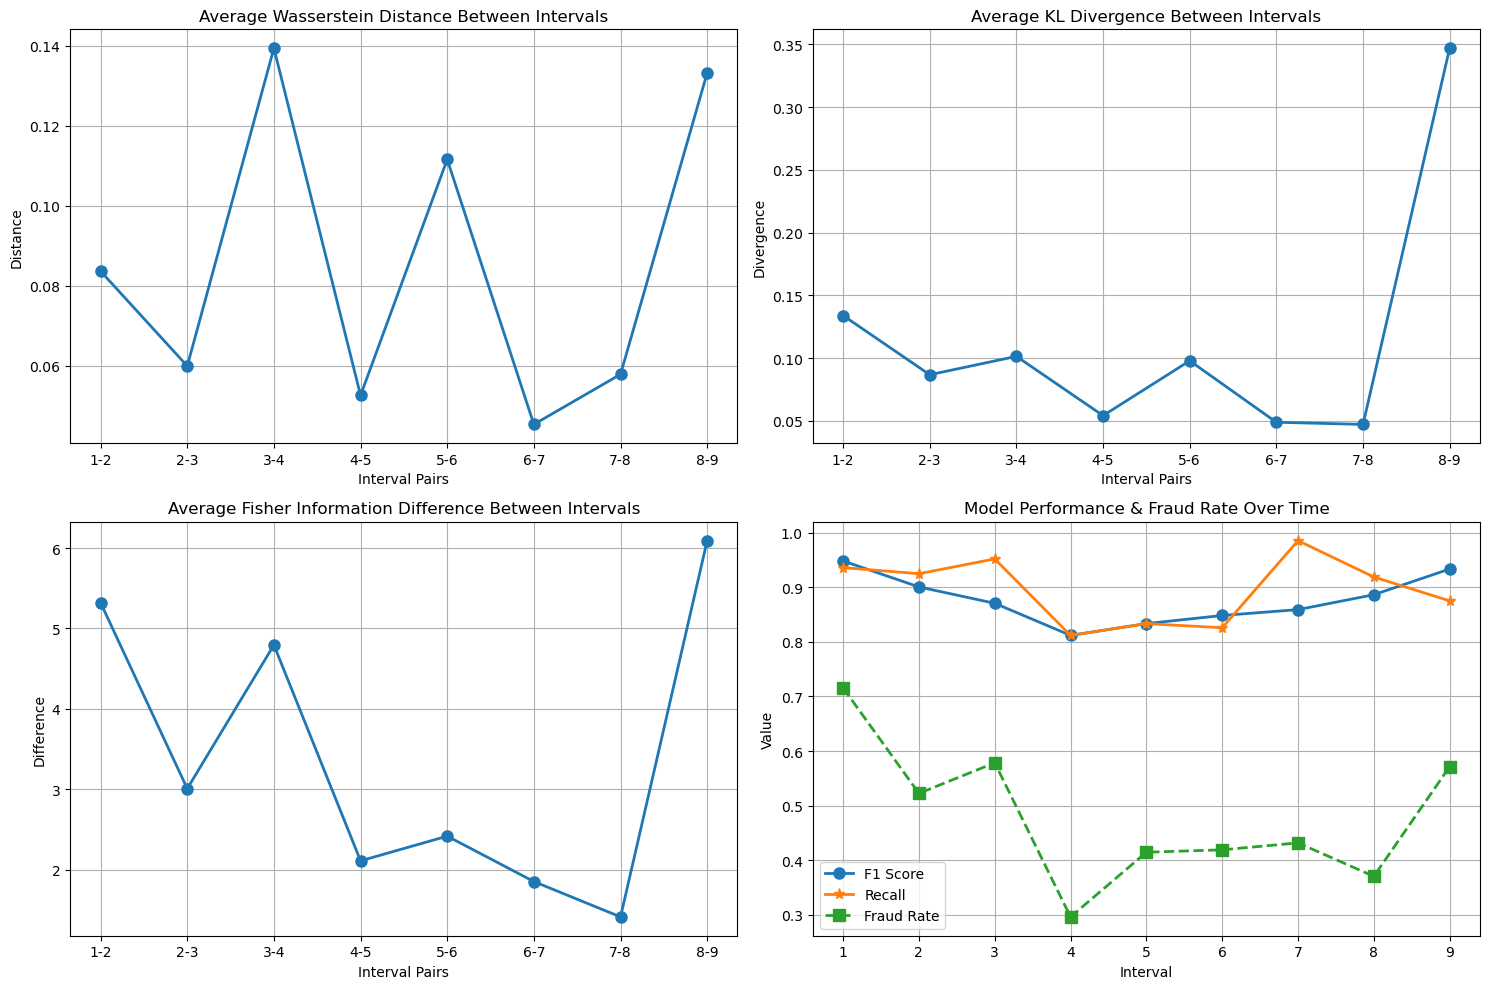

In [5]:
import matplotlib.pyplot as plt
# import seaborn as sns

# Visualize drift over time
plt.figure(figsize=(15, 10))

# Extract drift metrics across interval pairs
interval_pairs = [r['interval_pair'] for r in drift_results]
wasserstein_values = [r['avg_wasserstein'] for r in drift_results]
kl_values = [r['avg_kl_divergence'] for r in drift_results]
fisher_values = [r['avg_fisher_diff'] for r in drift_results]

# Plot drift metrics
plt.subplot(2, 2, 1)
plt.plot(interval_pairs, wasserstein_values, 'o-', linewidth=2, markersize=8)
plt.title('Average Wasserstein Distance Between Intervals')
plt.xlabel('Interval Pairs')
plt.ylabel('Distance')
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(interval_pairs, kl_values, 'o-', linewidth=2, markersize=8)
plt.title('Average KL Divergence Between Intervals')
plt.xlabel('Interval Pairs')
plt.ylabel('Divergence')
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(interval_pairs, fisher_values, 'o-', linewidth=2, markersize=8)
plt.title('Average Fisher Information Difference Between Intervals')
plt.xlabel('Interval Pairs')
plt.ylabel('Difference')
plt.grid(True)

# Plot model performance over intervals
interval_indices = list(range(1, len(intervals) + 1))
f1_scores = []
recalls = []
fraud_rates = []

for interval in intervals:
    # Calculate fraud rate in interval
    fraud_rate = interval['target'].mean()
    fraud_rates.append(fraud_rate)
    
    # Evaluate model on interval
    X_interval = scaler.transform(interval[features])
    y_interval = interval['target']
    y_pred_interval = model.predict(X_interval)
    
    # Calculate performance
    _, recall, f1, _ = precision_recall_fscore_support(
        y_interval, y_pred_interval, average='binary', zero_division=0)
    recalls.append(recall)
    f1_scores.append(f1)

plt.subplot(2, 2, 4)
plt.plot(interval_indices, f1_scores, 'o-', linewidth=2, markersize=8, label='F1 Score')
plt.plot(interval_indices, recalls, '*-', linewidth=2, markersize=8, label='Recall')
plt.plot(interval_indices, fraud_rates, 's--', linewidth=2, markersize=8, label='Fraud Rate')
plt.title('Model Performance & Fraud Rate Over Time')
plt.xlabel('Interval')
plt.ylabel('Value')
plt.legend()
plt.grid(True)

plt.tight_layout()
# plt.savefig('drift_analysis.png')
plt.show()

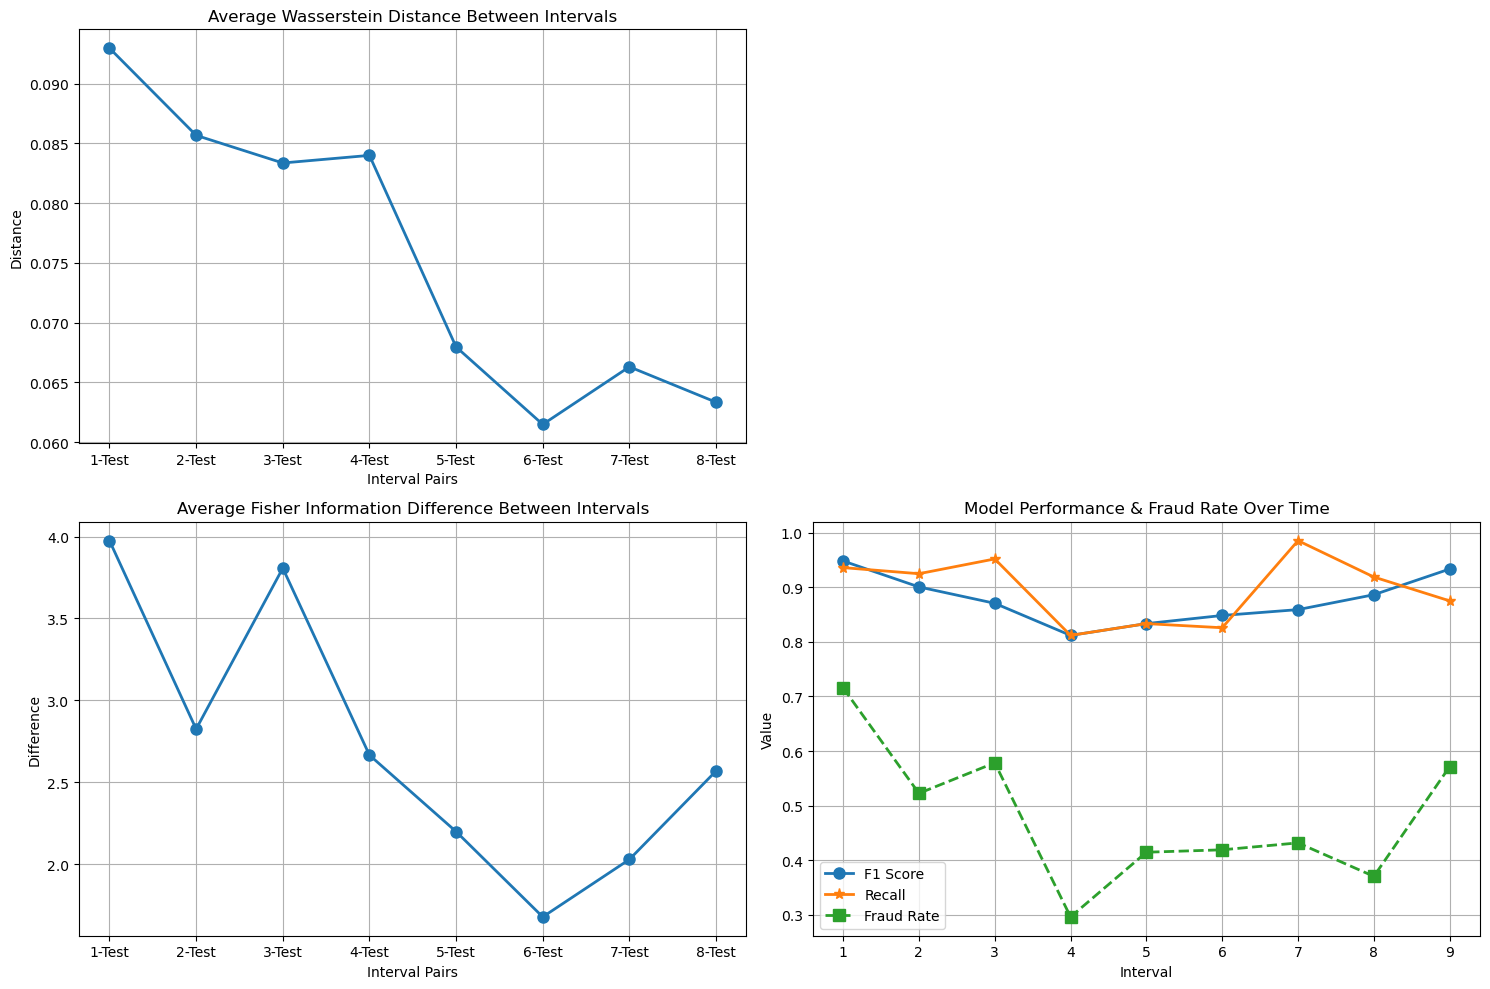

In [10]:
import matplotlib.pyplot as plt
# import seaborn as sns

# Visualize drift over time
plt.figure(figsize=(15, 10))

# Extract drift metrics across interval pairs
interval_pairs = [r['interval_pair'] for r in test_drift_results]
wasserstein_values = [r['avg_wasserstein'] for r in test_drift_results]
kl_values = [r['avg_kl_divergence'] for r in test_drift_results]
fisher_values = [r['avg_fisher_diff'] for r in test_drift_results]

# Plot drift metrics
plt.subplot(2, 2, 1)
plt.plot(interval_pairs, wasserstein_values, 'o-', linewidth=2, markersize=8)
plt.title('Average Wasserstein Distance Between Intervals')
plt.xlabel('Interval Pairs')
plt.ylabel('Distance')
plt.grid(True)

# plt.subplot(2, 2, 2)
# plt.plot(interval_pairs, kl_values, 'o-', linewidth=2, markersize=8)
# plt.title('Average KL Divergence Between Intervals')
# plt.xlabel('Interval Pairs')
# plt.ylabel('Divergence')
# plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(interval_pairs, fisher_values, 'o-', linewidth=2, markersize=8)
plt.title('Average Fisher Information Difference Between Intervals')
plt.xlabel('Interval Pairs')
plt.ylabel('Difference')
plt.grid(True)

# Plot model performance over intervals
interval_indices = list(range(1, len(intervals) + 1))
f1_scores = []
recalls = []
fraud_rates = []

for interval in intervals:
    # Calculate fraud rate in interval
    fraud_rate = interval['target'].mean()
    fraud_rates.append(fraud_rate)
    
    # Evaluate model on interval
    X_interval = scaler.transform(interval[features])
    y_interval = interval['target']
    y_pred_interval = model.predict(X_interval)
    
    # Calculate performance
    _, recall, f1, _ = precision_recall_fscore_support(
        y_interval, y_pred_interval, average='binary', zero_division=0)
    recalls.append(recall)
    f1_scores.append(f1)

plt.subplot(2, 2, 4)
plt.plot(interval_indices, f1_scores, 'o-', linewidth=2, markersize=8, label='F1 Score')
plt.plot(interval_indices, recalls, '*-', linewidth=2, markersize=8, label='Recall')
plt.plot(interval_indices, fraud_rates, 's--', linewidth=2, markersize=8, label='Fraud Rate')
plt.title('Model Performance & Fraud Rate Over Time')
plt.xlabel('Interval')
plt.ylabel('Value')
plt.legend()
plt.grid(True)

plt.tight_layout()
# plt.savefig('drift_analysis.png')
plt.show()